## Circuit cutting with quantum serverless

###### Import the circuit we wish to cut, the necessary Runtime objects, and the wire cutting functions

In [11]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    Options,
)
from quantum_serverless import QuantumServerless, get

from circuit_knitting_toolbox.circuit_cutting.wire_cutting import (
    cut_circuit_wires,
    evaluate_subcircuits,
    reconstruct_full_distribution,
    verify,
)

##### Parametrize the circuit and visualize it

In [12]:
num_qubits = 8
circuit = EfficientSU2(
    num_qubits=num_qubits,
    reps=2,
    entanglement="linear",
    su2_gates=["ry"],
    insert_barriers=False,
)

circuit = circuit.decompose()

params = [(np.pi * i) / 16 for i in range(len(circuit.parameters))]
circuit = circuit.bind_parameters(params)
circuit.draw(fold=300)

┌─────────┐      ┌─────────┐                           ┌───────┐                                                                                                                            
q_0: ─┤ Ry(0.0) ├───■──┤ Ry(π/2) ├──────────────────■────────┤ Ry(π) ├────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      ├─────────┴┐┌─┴─┐└─────────┘┌───────────┐   ┌─┴─┐      └───────┘   ┌──────────────────────┐                                                                                                 
q_1: ─┤ Ry(π/16) ├┤ X ├─────■─────┤ Ry(9π/16) ├───┤ X ├──────────■───────┤ Ry(3.33794219443916) ├─────────────────────────────────────────────────────────────────────────────────────────────────
      ├─────────┬┘└───┘   ┌─┴─┐   └───────────┘┌──┴───┴───┐    ┌─┴─┐     └──────────────────────┘ ┌──────────┐                                                                                    
q_2: ─┤ Ry(π/8) ├─────────┤ X ├─────────■──────┤ Ry(5π/8) ├────┤ X ├────────────────■─────────────┤ Ry(9π/8) ├────────────────────────────────────────────────────────────────────────────────────
     ┌┴─────────┴┐        └───┘       ┌─┴─┐    └──────────┘┌───┴───┴────┐         ┌─┴─┐           └──────────┘ ┌──────────────────────┐                                                           
q_3: ┤ Ry(3π/16) ├────────────────────┤ X ├─────────■──────┤ Ry(11π/16) ├─────────┤ X ├────────────────■───────┤ Ry(3.73064127613788) ├───────────────────────────────────────────────────────────
     └┬─────────┬┘                    └───┘       ┌─┴─┐    └────────────┘      ┌──┴───┴───┐          ┌─┴─┐     └──────────────────────┘┌──────────┐                                               
q_4: ─┤ Ry(π/4) ├─────────────────────────────────┤ X ├──────────■─────────────┤ Ry(3π/4) ├──────────┤ X ├────────────────■────────────┤ Ry(5π/4) ├───────────────────────────────────────────────
     ┌┴─────────┴┐                                └───┘        ┌─┴─┐           └──────────┘      ┌───┴───┴────┐         ┌─┴─┐          └──────────┘┌─────────────────────┐                        
q_5: ┤ Ry(5π/16) ├─────────────────────────────────────────────┤ X ├────────────────■────────────┤ Ry(13π/16) ├─────────┤ X ├───────────────■──────┤ Ry(4.1233403578366) ├────────────────────────
     └┬──────────┤                                             └───┘              ┌─┴─┐          └────────────┘      ┌──┴───┴───┐         ┌─┴─┐    └─────────────────────┘     ┌───────────┐      
q_6: ─┤ Ry(3π/8) ├────────────────────────────────────────────────────────────────┤ X ├────────────────■─────────────┤ Ry(7π/8) ├─────────┤ X ├───────────────■────────────────┤ Ry(11π/8) ├──────
     ┌┴──────────┤                                                                └───┘              ┌─┴─┐          ┌┴──────────┴┐        └───┘             ┌─┴─┐         ┌────┴───────────┴─────┐
q_7: ┤ Ry(7π/16) ├───────────────────────────────────────────────────────────────────────────────────┤ X ├──────────┤ Ry(15π/16) ├──────────────────────────┤ X ├─────────┤ Ry(4.51603943953533) ├
     └───────────┘                                                                                   └───┘          └────────────┘                          └───┘         └──────────────────────┘

##### Set up the QuantumServerless object
 * We will use our local CPU cores as our cluster for this demo
 * We will see commented examples of how one might change the quantum serverless context throughout the workflow

In [14]:
serverless = QuantumServerless()
serverless.providers()

[<Provider: local>]

##### Find cuts that match our criteria.
   * Use a mixed integer programming (MIP) model to find cuts automatically
   * Only allow subcircuits which are 6 qubits or less
   * Cut the circuit no more than two times
   * Allow no more than 2 subcircuits
   
##### Note, the cutting routine could be sent to a specific provider -- We show how one might send this piece of code to an Azure remote cluster. 

In [16]:
# serverless.set_provider("azure")
with serverless:
    # Get a future object
    cuts_future = cut_circuit_wires(
        circuit=circuit,
        method="automatic",
        max_subcircuit_width=6,
        max_cuts=2,
        num_subcircuits=[2],
    )
    # Collect the results of the remote cutting function
    cuts = get(cuts_future)

(cut_circuit_wires pid=39130) Exporting as a LP file to let you check the model that will be solved :  inf <class 'float'>
(cut_circuit_wires pid=39130) Version identifier: 22.1.0.0 | 2022-03-27 | 54982fbec
(cut_circuit_wires pid=39130) CPXPARAM_Read_DataCheck                          1
(cut_circuit_wires pid=39130) CPXPARAM_TimeLimit                               300
(cut_circuit_wires pid=39130) Warning:  Non-integral bounds for integer variables rounded.
(cut_circuit_wires pid=39130) Tried aggregator 3 times.
(cut_circuit_wires pid=39130) MIP Presolve eliminated 37 rows and 8 columns.
(cut_circuit_wires pid=39130) MIP Presolve modified 7 coefficients.
(cut_circuit_wires pid=39130) Aggregator did 103 substitutions.
(cut_circuit_wires pid=39130) Reduced MIP has 366 rows, 127 columns, and 1072 nonzeros.
(cut_circuit_wires pid=39130) Reduced MIP has 121 binaries, 6 generals, 0 SOSs, and 0 indicators.
(cut_circuit_wires pid=39130) Presolve time = 0.00 sec. (2.10 ticks)
(cut_circuit_wires

##### Set up the runtime configuration

In [21]:
service = QiskitRuntimeService(
    channel="ibm_quantum",
    token="<YOUR_API_TOKEN>",
)

# Set the Sampler and runtime options
options = Options(execution={"shots": 4000})

# Run 2 parallel qasm simulator threads
backend_names = ["ibmq_qasm_simulator"] * 2

##### Evaluate the subcircuits on the backend
 * Two local cores will be used to support each of the parallel backend threads
 * If no service_args are passed, a local statevector simulator will be used.
 * If service_args are passed, the runtime options and backend list will be used. We will use two parallel runtime qasm simulators for this tutorial.
 
##### Note, the evaluate routine could be sent to hardware near to the quantum device to improve performance. We show how one might specify a specific IBM cluster here.

In [22]:
# Evaluate the subcircuits on backend
# serverless.set_provider("ibm")
with serverless:
    # Get a future object
    subcircuit_probability_futures = evaluate_subcircuits(
        cuts,
        service_args=service.active_account(),
        backend_names=backend_names,
        options=options,
    )

    # Collect the results of the remote evaluate function
    subcircuit_instance_probabilities = get(subcircuit_probability_futures)

##### Reconstruct the results of the subcircuit experiments into an estimate of the original circuit's full probability distribution

##### Note, the reconstruct routine could be sent to a specific provider -- We show how one might send this piece of code to an AWS remote cluster. 

In [23]:
%%capture

# serverless.set_provider("aws")
with serverless:
    # Get a future object
    reconstructed_probabilities_future = reconstruct_full_distribution(
        circuit, subcircuit_instance_probabilities, cuts
    )

    # Collect the results of the remote evaluate function
    reconstructed_probabilities = get(reconstructed_probabilities_future)

##### If the original circuit is small enough, we can use a statevector simulator to check the results of cutting against the original circuit's true probability distribution

In [24]:
metrics = verify(circuit, reconstructed_probabilities)
metrics

{'nearest': {'chi2': 0.010604190720749253,
  'Mean Squared Error': 5.555842565101729e-07,
  'Mean Absolute Percentage Error': 1819.841745907062,
  'Cross Entropy': 3.617461297115183,
  'HOP': 0.9927545009191179},
 'naive': {'chi2': 0.0106529079640392,
  'Mean Squared Error': 5.467461710258269e-07,
  'Mean Absolute Percentage Error': 2491.071884037345,
  'Cross Entropy': 3.6019823484575135,
  'HOP': 0.9917652572489821}}

##### If we calculated the true probabilities, we can visualize the estimated and true probabilities together and compare

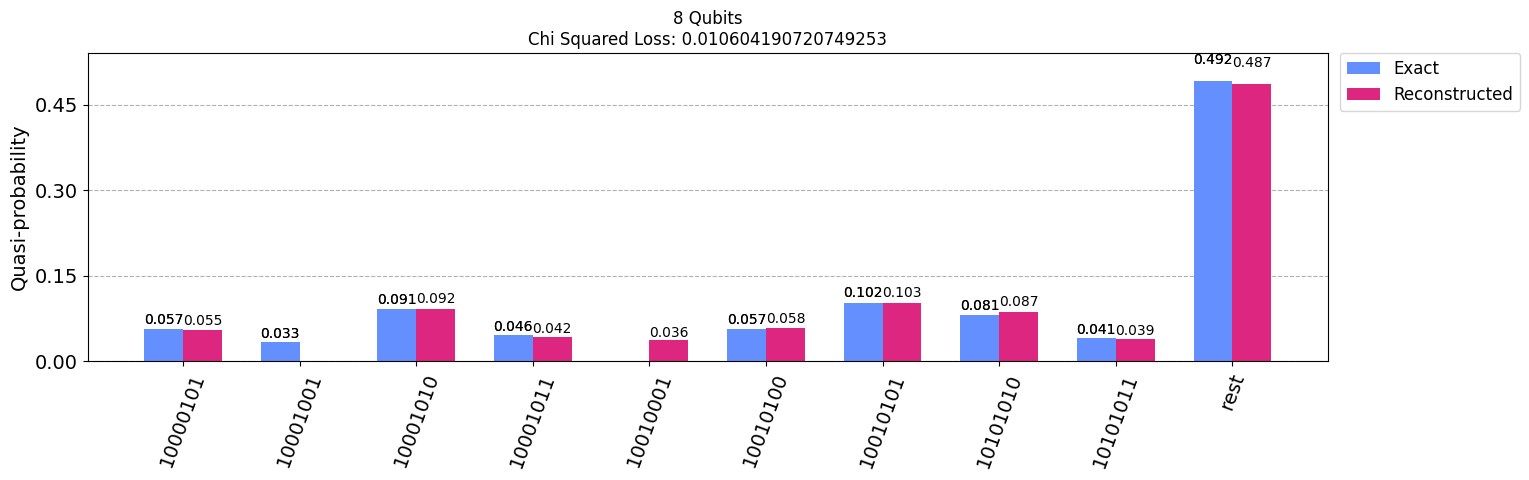

In [25]:
from qiskit import Aer
from qiskit.result import ProbDistribution
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

# Get the estimated distribution
reconstructed_distribution = {
    i: prob for i, prob in enumerate(reconstructed_probabilities)
}

# Get the true distribution
simulator = Aer.get_backend("statevector_simulator")
result = simulator.run(circuit).result()
statevector = result.get_statevector(circuit)
true_distribution = {
    i: prob for i, prob in enumerate(Statevector(statevector).probabilities())
}

true_dict_bitstring = ProbDistribution(data=true_distribution).binary_probabilities(
    num_bits=num_qubits
)
reconstructed_dict_bitstring = ProbDistribution(
    data=reconstructed_distribution
).binary_probabilities(num_bits=num_qubits)

plot_histogram(
    [true_dict_bitstring, reconstructed_dict_bitstring],
    number_to_keep=8,
    figsize=(16, 4),
    sort="asc",
    legend=["Exact", "Reconstructed"],
    title="{} Qubits\nChi Squared Loss: {}".format(
        num_qubits, metrics["nearest"]["chi2"]
    ),
)